In [3]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

In [6]:
def euro_values(S0, K, r, sigma, T,D = 0):
    d1 = (math.log(S0/K) + (r + 1/2*sigma**2)*T)/(sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    c = S0*math.exp(-D*T)*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2)
    p = K*math.exp(-r*T)*norm.cdf(-d2) - S0*math.exp(-D*T)*norm.cdf(-d1)
    delta_c = norm.cdf(d1)
    return c, p, delta_c

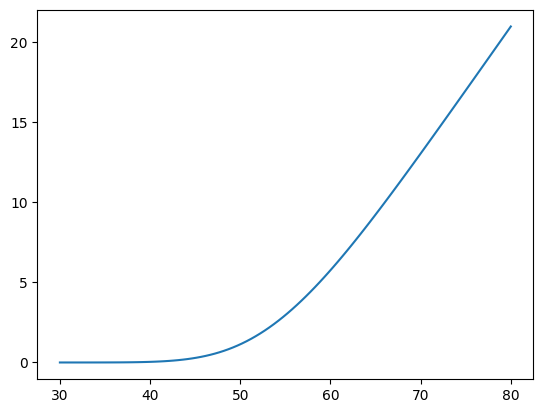

In [7]:
list_prices = []
for stock_price in np.linspace(30, 70, 100):
    list_prices.append(euro_values(stock_price, 50, 0.05, 0.2, 0.3846)[0])
plt.plot(np.linspace(30, 80, 100), list_prices)

Text(0.5, 1.0, 'Delta Change with Time')

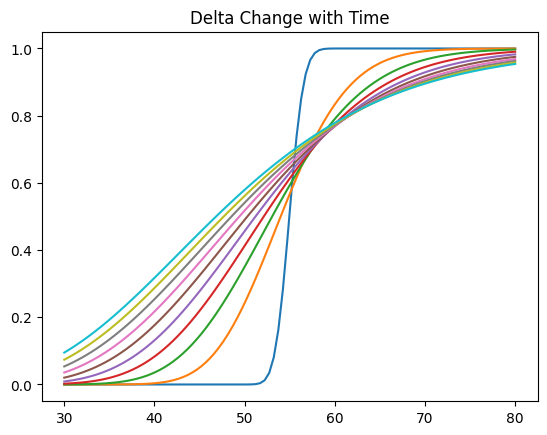

In [21]:
for maturity in np.linspace(0.01, 2, 10):
    list_prices = []
    for stock_price in np.linspace(30, 70, 100):
        list_prices.append(euro_values(stock_price, 50, 0.05, 0.2, maturity)[2])
    plt.plot(np.linspace(30, 80, 100), list_prices)
plt.title("Delta Change with Time")

In [23]:
euro_values(1200, 1140, 0.06, 0.30, 1/2,0.03)

(139.00204148658395, 63.1756222082081, 0.6876804841925694)